## Initial imports

In [12]:
import scm.plams as plams
from scm.simple_active_learning import SimpleActiveLearningJob
from scm.reactmap.tools import reorder_plams_mol
import matplotlib.pyplot as plt
from scm.input_classes import drivers, engines
from scm.libbase import Units
import scm.params as params
import os
import numpy as np

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/temp/sal-rb-unc-pkx-2024-Mar-28/plams_workdir.002


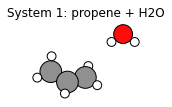

In [3]:
system1 = plams.from_smiles("CC=C", forcefield="uff")  # propene

# add a water molecule *at least* 1 angstrom away from all propene atoms
system1.add_molecule(plams.from_smiles("O"), margin=1)

for at in system1:
    at.properties = plams.Settings()
system1.delete_all_bonds()

plams.plot_molecule(system1)
plt.title("System 1: propene + H2O");

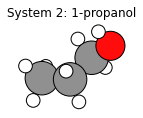

In [4]:
system2 = plams.from_smiles("CCCO")  # 1-propanol
for at in system2:
    at.properties = plams.Settings()
system2.delete_all_bonds()

# reorder atoms in system2 to match the order in system1
# this only takes bond breaking and forming into account, the order is not guaranteed to match exactly for all atoms
system2 = reorder_plams_mol(system1, system2)

# Rotate system2 so that the RMSD with respect to system1 is minimized
system2.align2mol(system1)

plams.plot_molecule(system2)
plt.title("System 2: 1-propanol");

In [5]:
# sanity-check that at least the order of elements is identical
assert list(system1.symbols) == list(system2.symbols), f"Something went wrong!"

Note that this does not guarantee that the atom order is completely the same.
For example the order of the hydrogen atoms in the CH3 group might be different.
This means that we cannot just run NEB directly. So let's first run MD ReactionBoost.

## Initial Reaction Boost to get reactant and product

### Engine settings

Here we use ``e_up`` to refer to the M3GNet Universal Potential.

For the ADF DFT engine we set an electronic temperature and the OptimizeSpinRound option. This helps with SCF convergence, and can converge the SCF to a different spin state when applicable.

In [6]:
e_up = engines.MLPotential()
e_up.Model = "M3GNet-UP-2022"

e_dft = engines.ADF()
e_dft.XC.GGA = "PBE"
e_dft.XC.Dispersion = "GRIMME3 BJDAMP"
e_dft.Basis.Type = "TZP"
e_dft.Unrestricted = True
e_dft.Occupations = "ElectronicTemperature=300 OptimizeSpinRound=0.05"

In [7]:
def set_reaction_boost(driver, nsteps=3000):
    driver.Task = "MolecularDynamics"
    md = driver.MolecularDynamics
    md.InitialVelocities.Temperature = 100
    md.NSteps = nsteps
    md.ReactionBoost.Type = "Pair"
    md.ReactionBoost.BondBreakingRestraints.Type = "Erf"
    md.ReactionBoost.BondBreakingRestraints.Erf.MaxForce = 0.05
    md.ReactionBoost.BondMakingRestraints.Type = "Erf"
    md.ReactionBoost.BondMakingRestraints.Erf.MaxForce = 0.12
    md.ReactionBoost.InitialFraction = 0.05
    md.ReactionBoost.Change = "LogForce"
    md.ReactionBoost.NSteps = nsteps
    md.ReactionBoost.TargetSystem[0] = "final"
    md.Trajectory.SamplingFreq = 10
    md.Trajectory.WriteBonds = False
    md.Trajectory.WriteMolecules = False
    md.TimeStep = 0.25
    md.Thermostat[0].Tau = 5
    md.Thermostat[0].Temperature = [100.0]
    md.Thermostat[0].Type = "Berendsen"

In [8]:
def get_reaction_boost_job(engine, molecule, name: str = "reaction_boost") -> plams.AMSJob:
    d = drivers.AMS()
    set_reaction_boost(d)
    d.Engine = engine
    job = plams.AMSJob(settings=d, name=name, molecule=molecule)
    job.settings.runscript.nproc = 1
    return job

In [9]:
molecule_dict = {"": system1, "final": system2}
prelim_job = get_reaction_boost_job(e_up, molecule_dict, "prelim_md")

In [10]:
prelim_job.run();

[03.04|14:11:30] JOB prelim_md STARTED
[03.04|14:11:30] JOB prelim_md RUNNING
[03.04|14:12:19] JOB prelim_md FINISHED
[03.04|14:12:19] JOB prelim_md SUCCESSFUL


Let's check that the final molecule corresponds to the target system (1-propanol):

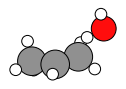

In [13]:
engine_energies = prelim_job.results.get_history_property("EngineEnergy")
N_frames = len(engine_energies)
max_index = np.argmax(engine_energies)
reactant_index = max(0, max_index - 50)  # zero-based
system1_correct_order = prelim_job.results.get_history_molecule(reactant_index + 1)
system1_correct_order.delete_all_bonds()
plams.plot_molecule(system1_correct_order)

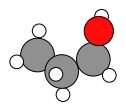

In [14]:
product_index = min(max_index + 50, N_frames - 1)  # zero-based
system2_correct_order = prelim_job.results.get_history_molecule(product_index + 1)
system1_correct_order.delete_all_bonds()
plams.plot_molecule(system2_correct_order)

We now have the product molecule with the correct atom order, which means we can run an initial NEB with M3GNet and compare to the DFT reference:

## Initial NEB calculation

In [15]:
molecule_dict = {"": system1_correct_order, "final": system2_correct_order}

In [16]:
def get_neb_job(engine, name: str = "neb") -> plams.AMSJob:
    d = drivers.AMS()
    d.Task = "NEB"
    d.GeometryOptimization.Convergence.Quality = "Basic"
    d.NEB.Images = 12
    d.Engine = engine

    neb_job = plams.AMSJob(name=name, settings=d, molecule=molecule_dict)
    return neb_job

In [17]:
neb_job = get_neb_job(e_up, name="neb_up")
neb_job.run();

[03.04|14:14:19] JOB neb_up STARTED
[03.04|14:14:19] JOB neb_up RUNNING
[03.04|14:14:45] JOB neb_up FINISHED
[03.04|14:14:46] JOB neb_up SUCCESSFUL


Let's then replay with the ADF DFT engine.

In [18]:
def get_replay_job(rkf, name="replay"):
    d_replay = drivers.AMS()
    d_replay.Task = "Replay"
    d_replay.Replay.File = os.path.abspath(rkf)
    d_replay.Properties.Gradients = True
    d_replay.Engine = e_dft

    replay_job = plams.AMSJob(name=name, settings=d_replay)
    return replay_job

In [19]:
replay_job = get_replay_job(neb_job.results.rkfpath(), "replay_neb")
replay_job.run();

[03.04|14:14:51] JOB replay_neb STARTED
[03.04|14:14:51] JOB replay_neb RUNNING
[03.04|14:15:57] JOB replay_neb FINISHED
[03.04|14:15:58] JOB replay_neb SUCCESSFUL


In [20]:
def get_relative_energies(neb_job):
    e = neb_job.results.get_neb_results()["Energies"]
    e = np.array(e) - np.min(e)
    e *= Units.get_factor("hartree", "eV")
    return e


def plot_neb_comparison(neb_job, replay_job, legend=None, title=None):
    energies_up = get_relative_energies(neb_job)
    energies_dft = get_relative_energies(replay_job)
    fig, ax = plt.subplots()
    ax.plot(energies_up)
    ax.plot(energies_dft)
    ax.legend(legend or ["M3GNet-UP-2022", "DFT singlepoints"])
    ax.set_ylabel("Relative energy (eV)")
    ax.set_title(title or "Reaction path water+propene -> 1-propanol")
    return ax

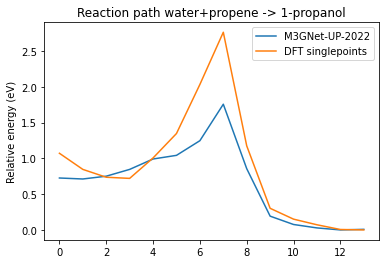

In [21]:
plot_neb_comparison(neb_job, replay_job);

So we can see that either M3GNet-UP-2022 underestimates the barrier or it NEB path is different from the DFT one. Let's use these datapoints as a starting point for the active learning.

Let's also run replay on some of the frames from the prelim_md reaction boost job:

In [22]:
replay_md = get_replay_job(prelim_job.results.rkfpath(), "replay_md")
N_frames_to_replay = 10
replay_md.settings.input.Replay.Frames = list(
    np.linspace(reactant_index, product_index, N_frames_to_replay, dtype=np.int64)
)
replay_md.run();

[03.04|14:16:22] JOB replay_md STARTED
[03.04|14:16:22] JOB replay_md RUNNING
[03.04|14:17:11] JOB replay_md FINISHED
[03.04|14:17:12] JOB replay_md SUCCESSFUL


## Simple Active Learning using Uncertainties

## Create the initial reference data

In [23]:
yaml_dir = "my_neb_data"
ri = params.ResultsImporter.from_ase()  # use ASE units
ri.add_trajectory_singlepoints(
    replay_job.results.rkfpath(), properties=["energy", "forces"], data_set="training_set"
)
ri.add_trajectory_singlepoints(
    replay_md.results.rkfpath(),
    properties=["energy", "forces"],
    data_set="training_set",
    indices=list(range(1, N_frames_to_replay - 1)),
)
ri.add_trajectory_singlepoints(
    replay_md.results.rkfpath(),
    properties=["energy", "forces"],
    indices=[0, N_frames_to_replay - 1],
    data_set="validation_set",
)
ri.store(yaml_dir, backup=False)

['my_neb_data/job_collection.yaml',
 'my_neb_data/results_importer_settings.yaml',
 'my_neb_data/training_set.yaml',
 'my_neb_data/validation_set.yaml']

When we have initial reference data like this, it's often most convenient to run a separate ParAMS training before starting the active learning.

This lets us sanity-check the training parameters, and more easily try different Active Learning settings without having to retrain the initial model every time.

In [24]:
def get_params_job(yaml_dir, load_model=None, name="paramsjob"):
    committee_size = 2
    paramsjob = params.ParAMSJob.from_yaml(yaml_dir, use_relative_paths=True, name=name)
    paramsjob.settings.input.Task = "MachineLearning"
    ml = paramsjob.settings.input.MachineLearning
    ml.Backend = "M3GNet"
    if load_model:
        ml.LoadModel = load_model
        ml.MaxEpochs = 200
        ml.M3GNet.LearningRate = 5e-4
    else:
        ml.M3GNet.Model = "Custom"
        ml.M3GNet.Custom.NumNeurons = 32
        ml.MaxEpochs = 300
        ml.M3GNet.LearningRate = 1e-3

    ml.CommitteeSize = committee_size
    paramsjob.settings.input.ParallelLevels.CommitteeMembers = committee_size

    return paramsjob

In [25]:
paramsjob = get_params_job(yaml_dir, name="custom_initial_training")
paramsjob.run();

[03.04|14:17:48] JOB custom_initial_training STARTED
[03.04|14:17:48] JOB custom_initial_training RUNNING
[03.04|14:20:57] JOB custom_initial_training FINISHED
[03.04|14:20:57] JOB custom_initial_training SUCCESSFUL


## Set up the active learning job

Here the key new setting is the ``ReasonableSimulationCriteria.GradientsUncertainty``. This setting will cause the MD simulation to instantly stop if the uncertainty is greater than 1.0 eV/angstrom.

This is useful since the ML model is unlikely to give good predictions for the new types of structures encountered during the reactive MD.

In the summary log, such an event will be marked as "FAILED" with the reason "GRADIENTS_UNCERTAINTY".

In order to use ML uncertainties, you need to train a committee model with at least 2 members. Here we set the commmittee size to 2. We also choose to train the 2 committee members in parallel. By default, they would be trained in sequence.

It is a good idea to train them in parallel if you have the computational resources to do so (for example, enough GPU memory).

When using uncertainty-based critiera, you may consider increasing the MaxAttemptsPerStep. Here, we stick with the default value of 15.

In [32]:
d_al = drivers.SimpleActiveLearning()
d_al.ActiveLearning.InitialReferenceData.Load.FromPreviousModel = True
d_al.ActiveLearning.Steps.Type = "Geometric"
d_al.ActiveLearning.Steps.Geometric.NumSteps = 5
d_al.ActiveLearning.Steps.Geometric.Start = 10
d_al.ActiveLearning.ReasonableSimulationCriteria.GradientsUncertainty.Enabled = True
d_al.ActiveLearning.ReasonableSimulationCriteria.GradientsUncertainty.MaxValue = 1.0  # eV/ang
d_al.ActiveLearning.SuccessCriteria.Forces.MinR2 = 0.4
d_al.ActiveLearning.MaxReferenceCalculationsPerAttempt = 3
d_al.ActiveLearning.MaxAttemptsPerStep = 15
d_al.MachineLearning.Backend = "M3GNet"
d_al.MachineLearning.LoadModel = os.path.abspath(paramsjob.results.path)
d_al.MachineLearning.CommitteeSize = 2
d_al.MachineLearning.MaxEpochs = 120
d_al.MachineLearning.M3GNet.LearningRate = 5e-4
d_al.MachineLearning.RunAMSAtEnd = False
d_al.ParallelLevels.CommitteeMembers = 2
set_reaction_boost(d_al)
d_al.Engine = e_dft

In [27]:
sal_job = SimpleActiveLearningJob(name="sal", driver=d_al, molecule=molecule_dict)
print(sal_job.get_input())

ActiveLearning
  InitialReferenceData
    Load
      FromPreviousModel True
    End
  End
  MaxReferenceCalculationsPerAttempt 3
  ReasonableSimulationCriteria
    GradientsUncertainty
      Enabled True
      MaxValue 1.0
    End
  End
  Steps
    Geometric
      NumSteps 5
      Start 10
    End
    Type Geometric
  End
  SuccessCriteria
    Forces
      MinR2 0.4
    End
  End
End
MachineLearning
  Backend M3GNet
  CommitteeSize 2
  LoadModel /home/hellstrom/temp/sal-rb-unc-pkx-2024-Mar-28/plams_workdir.002/custom_initial_training/results
  M3GNet
    LearningRate 0.0005
  End
  MaxEpochs 120
  RunAMSAtEnd False
End
MolecularDynamics
  InitialVelocities
    Temperature 100.0
  End
  NSteps 3000
  ReactionBoost
    BondBreakingRestraints
      Erf
        MaxForce 0.05
      End
      Type Erf
    End
    BondMakingRestraints
      Erf
        MaxForce 0.12
      End
      Type Erf
    End
    Change LogForce
    InitialFraction 0.05
    NSteps 3000
    TargetSystem final
    Type Pa

In [28]:
sal_job.run(watch=True)

[03.04|14:22:56] JOB sal STARTED
[03.04|14:22:56] JOB sal RUNNING
[03.04|14:22:58] Simple Active Learning 2024.101,  Nodes: 1, Procs: 8
[03.04|14:23:01] Composition of main system: C3H8O
[03.04|14:23:01] All REFERENCE calculations will be performed with the following ADF engine:
[03.04|14:23:01]
Engine adf
  basis
    type TZP
  End
  occupations ElectronicTemperature=300 OptimizeSpinRound=0.05
  unrestricted True
  xc
    dispersion GRIMME3 BJDAMP
    gga PBE
  End
EndEngine


[03.04|14:23:01] The following are the settings for the to-be-trained MACHINE LEARNING model:
[03.04|14:23:01]
MachineLearning
  Backend M3GNet
  CommitteeSize 2
  LoadModel /home/hellstrom/temp/sal-rb-unc-pkx-2024-Mar-28/plams_workdir.002/custom_initial_training/results
  M3GNet
    LearningRate 0.0005
  End
  MaxEpochs 120
  RunAMSAtEnd False
End

ParallelLevels
  CommitteeMembers 2
End

[03.04|14:23:01] A committee model with 2 members will be trained.
[03.04|14:23:01] The ACTIVE LEARNING loop will contain 5 

Above we see that during step 5, several attempts failed with the message GRADIENTS_UNCERTAINTY. It is during step 5 that the actual reaction happens. We do not know exactly at what time the reaction will happen (since the ReactionBoost gradually increases the applied force).

In such a case it is useful to have the GradientsUncertainty reasonable simulation criterion. This will immediately stop the simulation when the uncertainty is too high and follow it with a retraining of the model.

## New NEB validation

Let's now evalulate with a second-round NEB and replay. ``sal_job.results.get_production_engine_settings()`` returns the engine settings in the PLAMS Settings format. Let's first convert it to a PISA Engine:

In [29]:
def settings2engine(settings):
    temporary_d = drivers.AMS.from_settings(settings)
    return temporary_d.Engine

In [30]:
e_new = settings2engine(sal_job.results.get_production_engine_settings())

Let's now create our own active learning loop for NEB where we run the NEB calculation with our trained potential, replay, add points to training set, retrain, rerun NEB etc.

We need to do this since MD SAL may not exactly sample the minimum energy path.

[03.04|16:53:38] JOB new_neb0 STARTED
[03.04|16:53:38] JOB new_neb0 RUNNING
[03.04|16:55:00] JOB new_neb0 FINISHED
[03.04|16:55:01] JOB new_neb0 SUCCESSFUL
[03.04|16:55:01] JOB new_replay0 STARTED
[03.04|16:55:01] JOB new_replay0 RUNNING
[03.04|17:00:56] JOB new_replay0 FINISHED
[03.04|17:00:56] JOB new_replay0 SUCCESSFUL
[03.04|17:00:57] JOB new_params0 STARTED
[03.04|17:00:57] JOB new_params0 RUNNING
[03.04|17:07:29] JOB new_params0 FINISHED
[03.04|17:07:29] JOB new_params0 SUCCESSFUL
[03.04|17:07:29] JOB new_neb1 STARTED
[03.04|17:07:29] JOB new_neb1 RUNNING
[03.04|17:08:37] JOB new_neb1 FINISHED
[03.04|17:08:38] JOB new_neb1 SUCCESSFUL
[03.04|17:08:38] JOB new_replay1 STARTED
[03.04|17:08:38] JOB new_replay1 RUNNING
[03.04|17:10:45] JOB new_replay1 FINISHED
[03.04|17:10:45] JOB new_replay1 SUCCESSFUL
[03.04|17:10:46] JOB new_params1 STARTED
[03.04|17:10:46] JOB new_params1 RUNNING
[03.04|17:17:55] JOB new_params1 FINISHED
[03.04|17:17:55] JOB new_params1 SUCCESSFUL
[03.04|17:17:56]

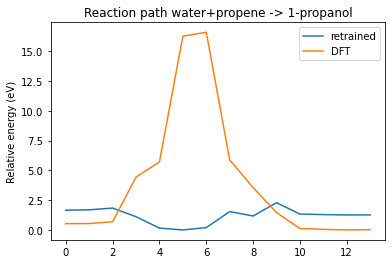

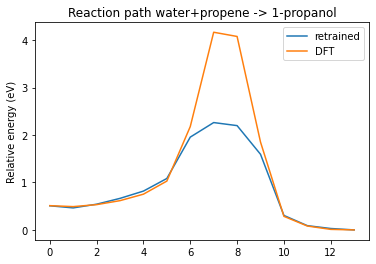

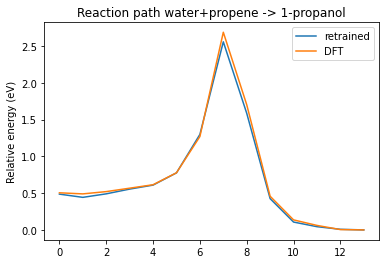

In [31]:
n_loop = 3
ri = params.ResultsImporter.from_yaml(sal_job.results.get_reference_data_directory())
params_results_dir = sal_job.results.get_params_results_directory()
for i in range(n_loop):
    neb = get_neb_job(e_new, f"new_neb{i}")
    neb.run()
    replay = get_replay_job(neb.results.rkfpath(), name=f"new_replay{i}")
    replay.run()
    plot_neb_comparison(neb, replay, legend=["retrained", "DFT"])
    yaml_dir = f"new_yaml_dir{i}"
    ri.add_trajectory_singlepoints(replay.results.rkfpath(), properties=["energy", "forces"])
    ri.store(yaml_dir, backup=False)
    paramsjob = get_params_job(yaml_dir, load_model=params_results_dir, name=f"new_params{i}")
    paramsjob.run()
    e_new = settings2engine(paramsjob.results.get_production_engine_settings())
    params_results_dir = os.path.abspath(paramsjob.results.path)